<a href="https://colab.research.google.com/github/dagyeom23658/Python_Practice/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%ED%95%A0%26%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EA%B0%95%26%26%EA%B0%9D%EC%B2%B4%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-nd6p5qvy
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-nd6p5qvy
  Created wheel for tensorflow-examples: filename=tensorflow_examples-03f796596c9ca9d3d42e5cb43a726b8e220c73b2_-py3-none-any.whl size=268214 sha256=db9ee61f6031cc73f0f3b93dcc3c3cdf5392593bd433b718ff5045d7993585fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-ou_u564v/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.0 MB 7.4 MB/s 


In [2]:
import tensorflow as tf

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [26]:
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [27]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
    

In [36]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

# ★input_mask는 뭐람.

In [29]:
@tf.function
def load_image_train(datapoint) :
    input_image = tf.image.resize(datapoint['image'],(128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

# 데이터 증강
    if tf.random.uniform(()) > 0.5 :
        input_image = tf.image.flip_left_right(input_image) # 좌우반전
        input_mask = tf.image.flip_left_right(input_mask)   # 레이블도 좌우반전
    
# 정규화
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [30]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.9668399>

In [42]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

# 정규화
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [32]:
info.splits['train']

<SplitInfo num_examples=3680, num_shards=4>

In [33]:
info.splits['train'].num_examples

3680

In [34]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE # // 나누기 후 소수점 버림

STEPS_PER_EPOCH

57

In [41]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE) # auto
test = dataset['test'].map(load_image_test)

In [43]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [44]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [46]:
train.take(100)

<TakeDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

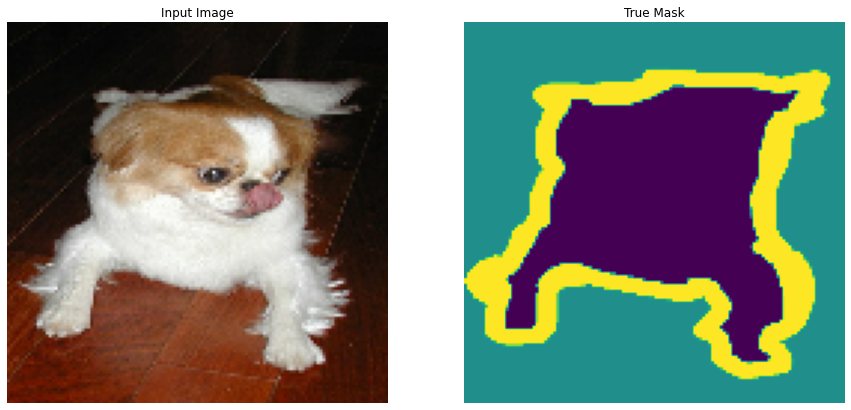

In [50]:
for image, mask in train.take(200):
    # print(image) # 어레이 행렬임
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

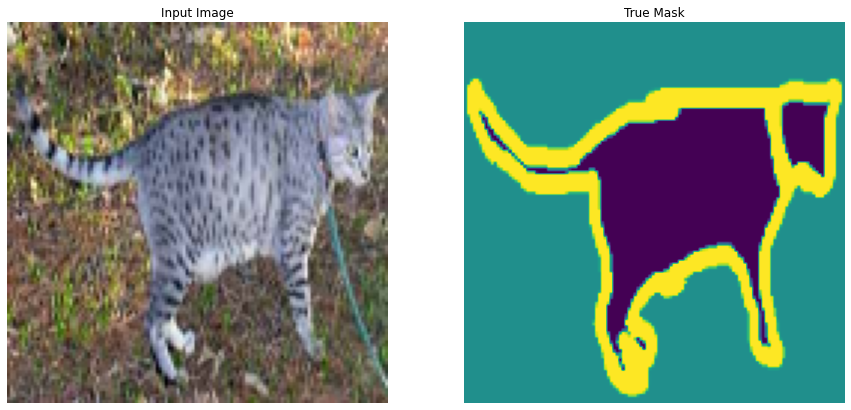

In [51]:
for image, mask in train.take(100):
    # print(image) # 어레이 행렬임
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

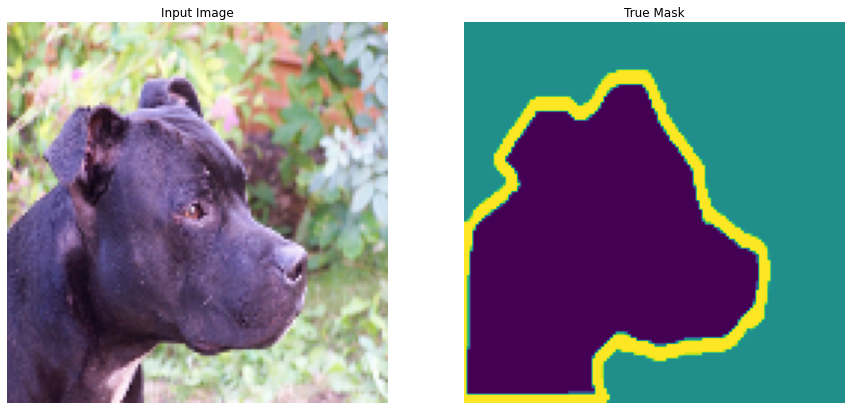

In [52]:
for image, mask in train.take(99):
    # print(image) # 어레이 행렬임
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

# U-Net

--> 인코더(다운샘플러)

--> 디코더(업샘플러)

In [53]:
OUTPUT_CHANNELS = 3

In [55]:
tf.keras.applications

<module 'keras.api._v2.keras.applications' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/applications/__init__.py'>

In [56]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False) # 기존 인풋사이즈 재사용 False

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]
layers

9420800/9406464 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

In [57]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [58]:
# 특징추출 모델 만들기

down_stack = tf.keras.Model(inputs = base_model.input, outputs=layers)
down_stack.trainable = False